In [2]:
# common packages 
import numpy as np 
import os
import copy
from math import *
import matplotlib.pyplot as plt
from functools import reduce
# reading in dicom files
import pydicom
# skimage image processing packages
from skimage import measure, morphology
from skimage.morphology import ball, binary_closing
from skimage.measure import label, regionprops
# scipy linear algebra functions 
from scipy.linalg import norm
import scipy.ndimage
# ipywidgets for some interactive plots
from ipywidgets.widgets import * 
import ipywidgets as widgets

## Load dicom files

In [3]:
def load_scan(path):
    slices = [pydicom.dcmread(path + '/' + s) for s in               
              os.listdir(path) if s[-3:]=='dcm']
    slices = [s for s in slices if 'SliceLocation' in s]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] -   
                          slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - 
                          slices[1].SliceLocation)
    for s in slices:
        s.SliceThickness = slice_thickness
    return slices

In [4]:
path = '/home/ujjwal/Projects/medical-training/RSNA/qer-2.0/1.2.276.0.7230010.3.1.2.8323329.1346.1548655530.986124/series/'
patient_dicom = load_scan(path)

## Meta data dicom

Meta data associated with dicom files

In [5]:
# rep = []
lines = str(patient_dicom).split("\n")
lines = [line + "\n" for line in lines]  # add the newline to end
# rep.append(lines)
# lines

In [6]:
meta = {}
meta_dict = {}
for line in lines:
    if line.split(":")[0][0] == '[' or line.split(":")[0][0] == '-':
        pass
    else:
        if len(line.split(":")) == 1:
            pass
        else:
            key_new = line.split(":")[0][line.find("("):line.find("(")+12]
            key_word = line.split(":")[0][-2:]
            meta[key_new]= line.split(":")[-1].strip()
            meta_dict[key_new] = key_word

In [7]:
meta

{'(0002, 0000)': '200',
 '(0002, 0001)': "b'\\x00\\x01'",
 '(0002, 0002)': 'CT Image Storage',
 '(0002, 0003)': '1.2.276.0.7230010.3.1.4.8323329.1346.1548655532.986288',
 '(0002, 0010)': 'JPEG Lossless, Non-Hierarchical, First-Order Prediction (Process 14 [Selection Value 1])',
 '(0002, 0012)': '1.2.276.0.7230010.3.0.3.6.2',
 '(0002, 0013)': "'OFFIS_DCMTK_362'",
 '(0008, 0005)': "'ISO_IR 100'",
 '(0008, 0008)': "['ORIGINAL', 'PRIMARY', 'AXIAL']",
 '(0008, 0016)': 'CT Image Storage',
 '(0008, 0018)': '1.2.276.0.7230010.3.1.4.8323329.1346.1548655532.986288',
 '(0008, 0020)': "'20170730'",
 '(0008, 0023)': "''",
 '(0008, 0030)': "''",
 '(0008, 0033)': "''",
 '(0008, 0050)': "''",
 '(0008, 0060)': "'CT'",
 '(0008, 0070)': "'TOSHIBA'",
 '(0008, 0090)': "'Charibert Tunnelly'",
 '(0008, 1030)': "'qER 2.0'",
 '(0008, 0100)': "'BRAINWO'",
 '(0008, 0102)': "'SYN99'",
 '(0008, 0104)': "'CT BRAIN PLAIN'",
 '(0008, 103e)': "'Head 4.0'",
 '(0008, 1090)': "'LCM'",
 '(0008, 2111)': "'Lossless JPEG com

## Convert pixel as per HU scaling

In [8]:
def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    image = image.astype(np.int16)
    
    # Convert to Hounsfield units (HU)
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(scans[0].RescaleIntercept)
    
    return np.array(image, dtype=np.int16)

<IPython.core.display.Javascript object>


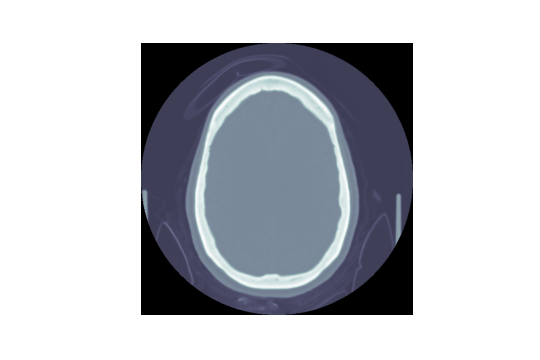

In [9]:
%matplotlib notebook
patient_pixels = get_pixels_hu(patient_dicom)
#sanity check
plt.axis('off')
plt.imshow(patient_pixels[23], cmap=plt.cm.bone)

## Slice viewer

In [10]:
def multi_slice_viewer(volume, windowing=False):
    remove_keymap_conflicts({'j', 'k'})
    fig, ax = plt.subplots()
    ax.volume = volume
    ax.index = volume.shape[0] // 2
    if windowing:
        # Defined using studies
        level, width = 30,70
#         level, width = patient_dicom[ax.index].WindowCenter, patient_dicom[ax.index].WindowWidth
        vmin = level - width/2
        vmax = level + width/2
        ax.imshow(volume[ax.index], cmap='gray', vmin=vmin, vmax=vmax)
    else:
        ax.imshow(volume[ax.index], cmap='gray')
    fig.canvas.mpl_connect('key_press_event', process_key)

def process_key(event):
    fig = event.canvas.figure
    ax = fig.axes[0]
    if event.key == 'j':
        previous_slice(ax)
    elif event.key == 'k':
        next_slice(ax)
    fig.canvas.draw()

def previous_slice(ax):
    volume = ax.volume
    ax.index = (ax.index - 1) % volume.shape[0]  # wrap around using %
    ax.images[0].set_array(volume[ax.index])

def next_slice(ax):
    volume = ax.volume
    ax.index = (ax.index + 1) % volume.shape[0]
    ax.images[0].set_array(volume[ax.index])

In [11]:
def remove_keymap_conflicts(new_keys_set):
    for prop in plt.rcParams:
        if prop.startswith('keymap.'):
            keys = plt.rcParams[prop]
            remove_list = set(keys) & new_keys_set
            for key in remove_list:
                keys.remove(key)

### Press J to move to previous slice and K to move to next slice.

<IPython.core.display.Javascript object>


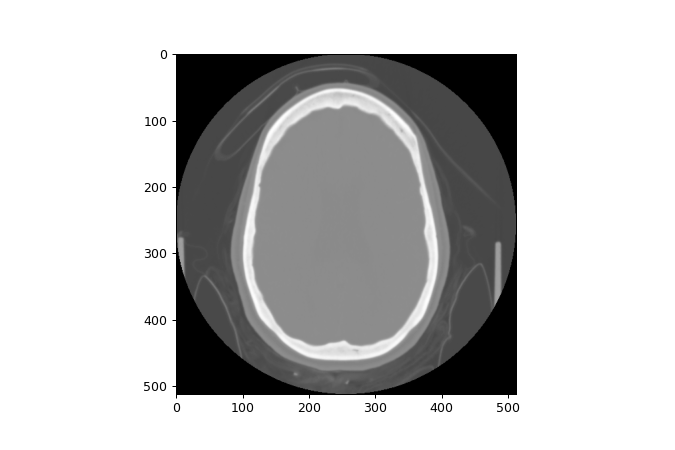

In [12]:
%matplotlib notebook
multi_slice_viewer(patient_pixels)

## Windowing

<IPython.core.display.Javascript object>


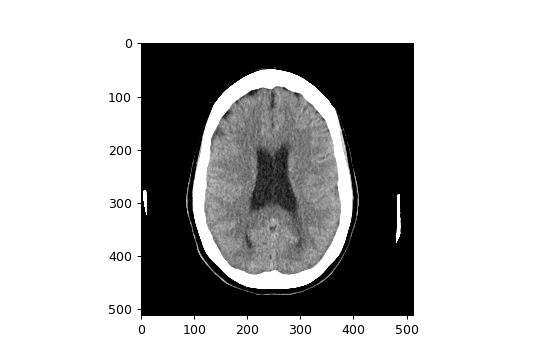

In [13]:
%matplotlib notebook
multi_slice_viewer(patient_pixels, windowing=True)

## Multiplanar Reconstruction

> Axial, sagittal and coronal images

![](https://images.ctfassets.net/cnu0m8re1exe/1k0YS9HKpsyurGlnI1Zlky/223cbf9b658b7068925ba7f944a9bb39/sagittal.jpg)

(512, 512, 42)


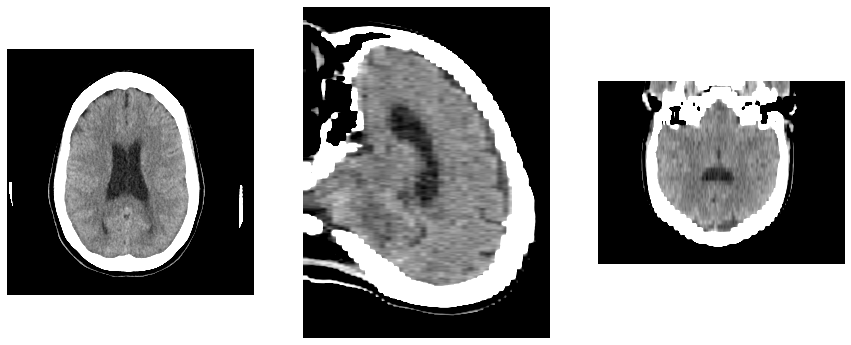

In [20]:
%matplotlib inline

# Defined using studies
level, width = 30,70
#         level, width = patient_dicom[ax.index].WindowCenter, patient_dicom[ax.index].WindowWidth
vmin = level - width/2
vmax = level + width/2

slices = sorted(patient_dicom, key=lambda s: s.SliceLocation)

# pixel aspects, assuming all slices are the same
pixel_spacing = slices[0].PixelSpacing
slice_thickness = slices[0].SliceThickness
ax_aspect = pixel_spacing[1]/pixel_spacing[0]
sag_aspect = pixel_spacing[1]/slice_thickness
cor_aspect = slice_thickness/pixel_spacing[0]

# create 3D array
img_shape = list(slices[0].pixel_array.shape)
img_shape.append(len(slices))
img3d = np.zeros(img_shape)

# fill 3D array with the images from the files
for i, s in enumerate(slices):
    img2d = s.pixel_array
    img3d[:, :, i] = img2d
    
print(img3d.shape)

# plot 3 orthogonal slices

fig = plt.figure(figsize=(15,15))

a1 = fig.add_subplot(1,3,1)
# a1 = plt.subplot(1, 3, 1)
a1.axis('off')
a1.imshow(img3d[:, :, img_shape[2]//2], cmap='gray', vmin=vmin, vmax=vmax)
a1.set_aspect(ax_aspect)
# a1.figure.savefig("axial.png", bbox_inches ="tight")

a2 = fig.add_subplot(1,3,2)
# a2 = plt.subplot(1, 3, 2)
a2.axis('off')
a2.imshow(img3d[:, img_shape[1]//2, :], cmap='gray', vmin=vmin, vmax=vmax)
a2.set_aspect(sag_aspect)
# a2.figure.savefig("sagittal.png", bbox_inches ="tight")

a3 = fig.add_subplot(1,3,3)
# a3 = plt.subplot(1, 3, 3)
a3.axis('off')
a3.imshow(img3d[img_shape[0]//2, :, :].T, cmap='gray', vmin=vmin, vmax=vmax)
a3.set_aspect(cor_aspect)
# a3.figure.savefig("coronal.png", bbox_inches ="tight")

fig.savefig('mpr.png')

## 3D construction

In [13]:
def make_mesh(image, threshold=-300, step_size=1):

    print ("Transposing surface")
    p = image.transpose(2,1,0)
    
    print ("Calculating surface")
    verts, faces, norm, val = measure.marching_cubes(p, threshold, step_size=step_size, allow_degenerate=True) 
    return verts, faces

def plotly_3d(verts, faces):
    x,y,z = zip(*verts) 
    
    print( "Drawing")
    
    # Make the colormap single color since the axes are positional not intensity. 
#    colormap=['rgb(255,105,180)','rgb(255,255,51)','rgb(0,191,255)']
    colormap=['rgb(236, 236, 212)','rgb(236, 236, 212)']
    
    fig = FF.create_trisurf(x=x,
                        y=y, 
                        z=z, 
                        plot_edges=False,
                        colormap=colormap,
                        simplices=faces,
                        backgroundcolor='rgb(64, 64, 64)',
                        title="Interactive Visualization")
    iplot(fig)

def plt_3d(verts, faces):
    print ("Drawing")
    x,y,z = zip(*verts) 
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], linewidths=0.05, alpha=1)
#     face_color = [1, 1, 0.9]
#     mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, max(x))
    ax.set_ylim(0, max(y))
    ax.set_zlim(0, max(z))
#     ax.set_facecolor((0.7, 0.7, 0.7))
    plt.show()

Transposing surface
Calculating surface
Drawing


<IPython.core.display.Javascript object>


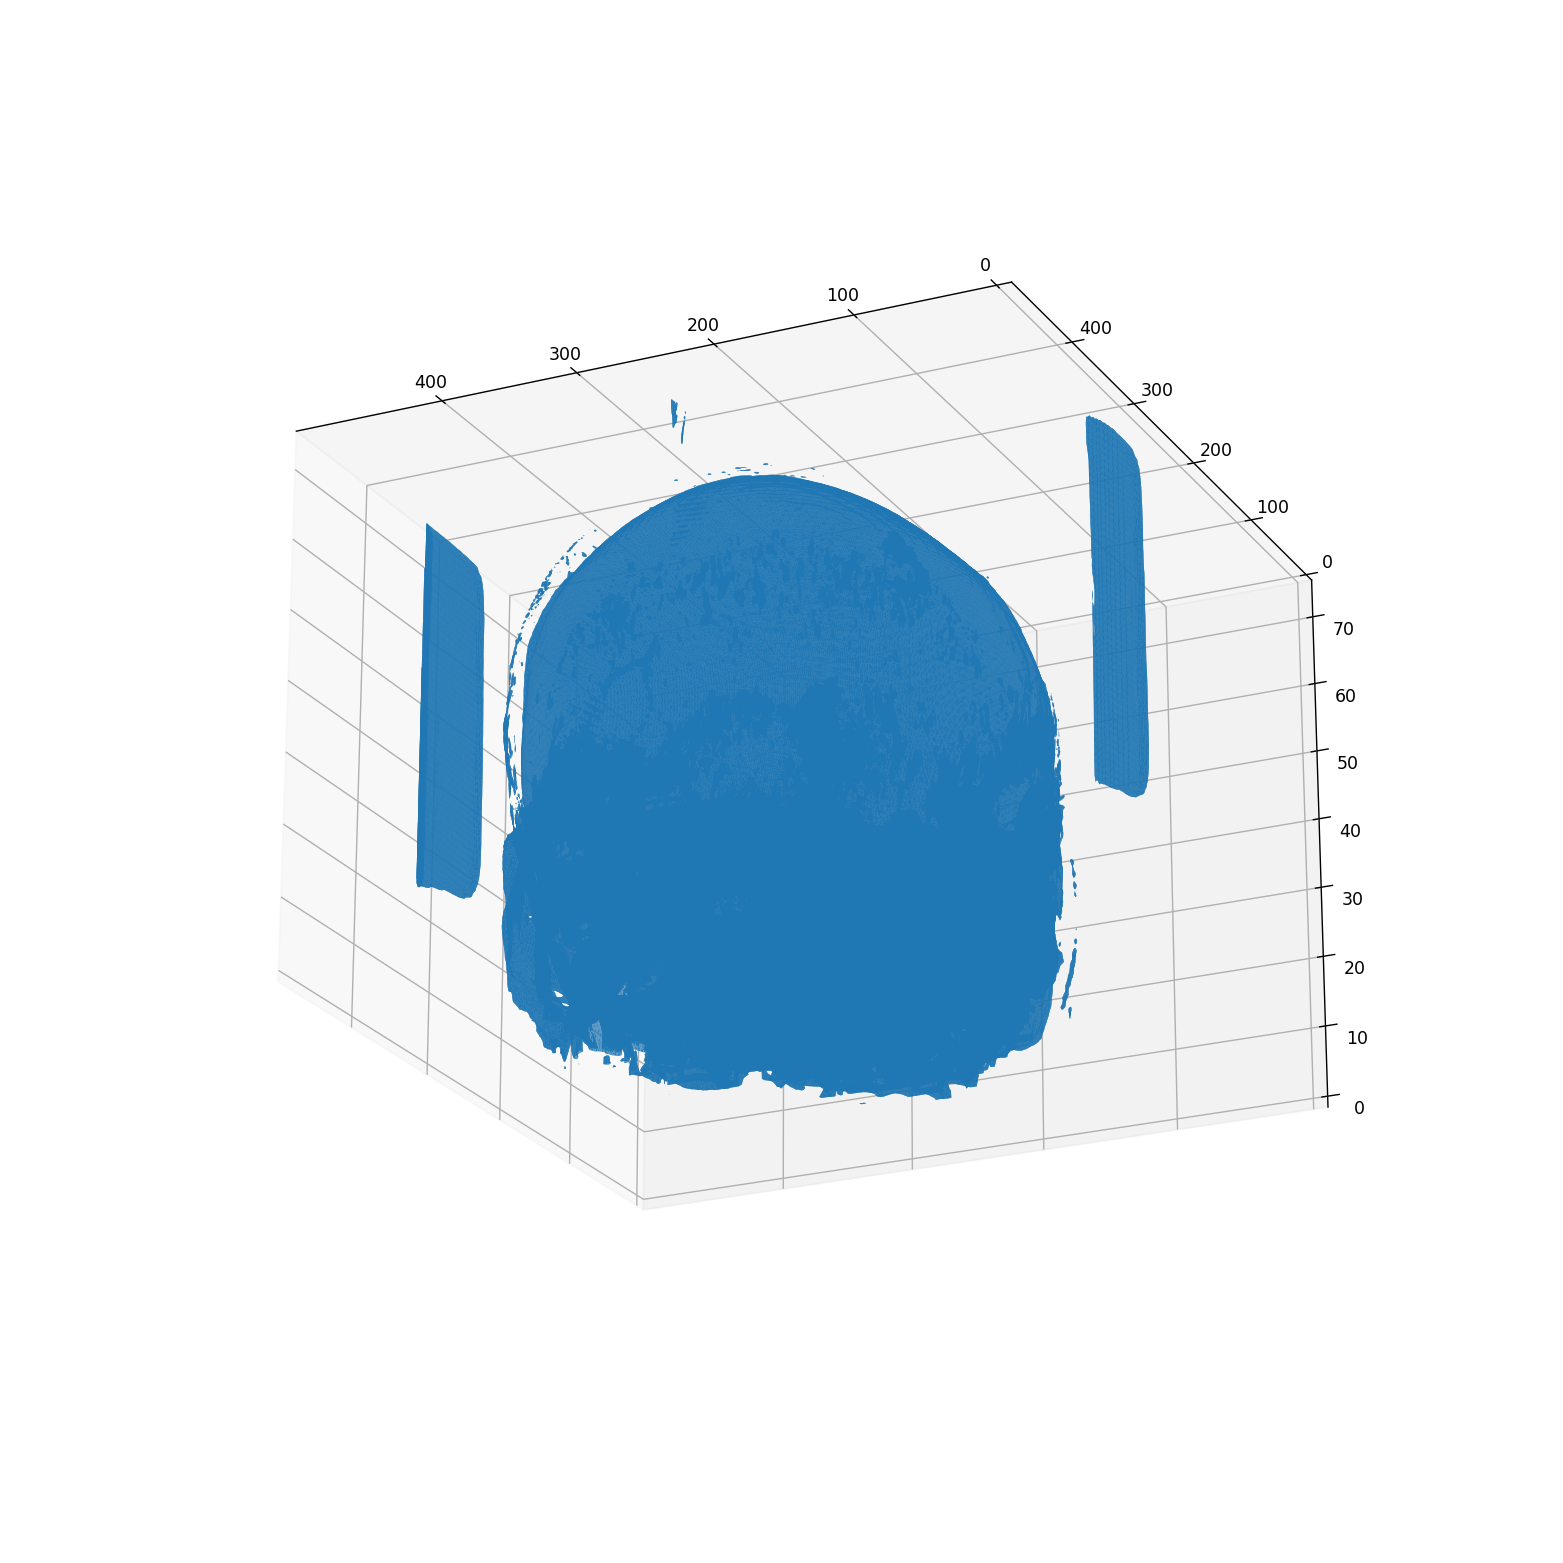

In [11]:
%matplotlib notebook
# Run at your own risk, it sometimes hangs the kernel.
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
v, f = make_mesh(patient_pixels, 0)
plt_3d(v, f)